In [1]:
from hdbcli import dbapi
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Connection database

In [2]:
connection = dbapi.connect('<ip-address>', 39015, 'SYSTEM', '<password>')
connection.isconnected()

True

In [3]:
cursor = connection.cursor()

# Teil 1

## 1. Ermitteln Sie die häufigsten Folgen von Adjektiv-Nomen Bigrammen im Corpus (Hinweis: wenn Sie mit SQL arbeiten, können Sie einen non-equi auto-join verwenden)

In [ ]:
sql = 'select top 10 t1.TA_TOKEN, t2.TA_TOKEN, count(*) from "SYSTEM"."$TA_CDESCRIND" as t1, "SYSTEM"."$TA_CDESCRIND" as t2 where t1.cmplid=t2.cmplid and t1.TA_COUNTER=t2.TA_COUNTER-1 and t1.TA_SENTENCE=t2.TA_SENTENCE and t1.TA_TYPE=\'adjective\' and t2.TA_TYPE=\'noun\' group by t1.TA_TOKEN, t2.TA_TOKEN order by count(*) desc'
cursor.execute(sql)
adjective_noun = cursor.fetchall()
adjective_noun_df = pd.DataFrame(adjective_noun)
adjective_noun_df.columns = ['adjective', 'noun', 'count']
adjective_noun_df

## 2. Ermitteln Sie die häufigsten Co-occurrences von Adjektiven innerhalb eines Satzes (Position egal).

In [ ]:
sql = 'select top 10 t1.TA_TOKEN as adjective, t2.TA_TOKEN as adjective2, count(*) from "SYSTEM"."$TA_CDESCRIND" as t1, "SYSTEM"."$TA_CDESCRIND" as t2 where t1.cmplid=t2.cmplid and t1.TA_COUNTER<t2.TA_COUNTER and t1.TA_SENTENCE=t2.TA_SENTENCE and t1.TA_TYPE=\'adjective\' and t2.TA_TYPE=\'adjective\' group by t1.TA_TOKEN, t2.TA_TOKEN order by count(*) desc'
cursor.execute(sql)
adj_adj = cursor.fetchall()
adj_adj_df = pd.DataFrame(adj_adj)
adj_adj_df.columns = ['adjective', 'adjective 2', 'count']
adj_adj_df

## 3. Berechnen Sie die top-3 tf-idf (ntn nach der SMART Notation) Werte von Nomen im Corpus. Schauen Sie sich die entsprechenden Dokumente und die jeweiligen tf bzw. idf Wertkomponenten an.

### tf

In [ ]:
# create SQL-View MAX_FREQ_NOUN
sql = 'create view MAX_FREQ_NOUN as select CMPLID as CMPLID, TA_TOKEN as noun, count(*) as tf from "$TA_CDESCRIND" where TA_TYPE=\'noun\' group by CMPLID, TA_TOKEN order by count(*) desc'
cursor.execute(sql)

In [ ]:
# drop SQL-View MAX_FREQ_NOUN
sql_drop_view = 'drop view MAX_FREQ_NOUN'
cursor.execute(sql_drop_view)

In [ ]:
# tf
sql = 'select top 3 CMPLID, noun, tf from MAX_FREQ_NOUN'
cursor.execute(sql)
tf = cursor.fetchall()
tf_df = pd.DataFrame(tf)
tf_df.columns = ['CMPLID','noun', 'tf']
tf_df

### idf

In [ ]:
# create SQL-View COUNT_DOCS
sql = 'create view COUNT_DOCS as select count(DISTINCT cmplid) as n_total from "SYSTEM"."$TA_CDESCRIND"'
cursor.execute(sql)

In [ ]:
# create SQL-View VALUES_DF
sql = 'create view VALUES_DF as select TA_TOKEN as noun, count(DISTINCT CMPLID) as DF from "$TA_CDESCRIND" where TA_TYPE=\'noun\' group by TA_TOKEN'
cursor.execute(sql)

In [ ]:
# create SQL-View VALUES_IDF
sql = 'create view VALUES_IDF as select t1.noun, ln((t2.n_total/t1.DF)) as idf from VALUES_DF as t1, COUNT_DOCS as t2 order by idf desc' 
cursor.execute(sql)

In [ ]:
# drop SQL-Views
sql_drop_view = 'drop view VALUES_IDF'
cursor.execute(sql_drop_view)

In [ ]:
# idf
sql = 'select top 3 * from VALUES_IDF'
cursor.execute(sql)
idf = cursor.fetchall()
idf_df = pd.DataFrame(idf)
idf_df.columns = ['noun', 'idf']
idf_df

### tf-idf

In [ ]:
sql = 'select top 3 t2.CMPLID, t1.noun, t2.tf, t1.idf, (t2.tf*t1.idf) as tfidf from VALUES_IDF as t1, MAX_FREQ_NOUN as t2 where t1.noun = t2.noun order by tfidf desc'
cursor.execute(sql)
idf = cursor.fetchall()
idf_df = pd.DataFrame(idf)
idf_df.columns = ['CMPLID', 'noun','tf', 'idf', 'tfidf']
idf_df

## 4. Berücksichtigen Sie nur Adjektiv-Nomen Bigramme in Dokumenten mit der ID<1000000. Ermitteln Sie anhand des Chi2 Tests die 3 statistisch signifikantesten und die 3 am wenigsten signifikant zusammenhängenden Bigramme mit w1=* (beliebig) und w2=Tire.

In [ ]:
# create view
# all adjective-noun bigrams with ID < 1000000 and w1=* and w2=Tire
sql = 'create view adjective_noun_bigram as select t1.TA_TOKEN as adjective, t2.TA_TOKEN as noun, count(*) as  w1_and_w2 from "SYSTEM"."$TA_CDESCRIND" as t1, "SYSTEM"."$TA_CDESCRIND" as t2 where t1.cmplid=t2.cmplid and t1.TA_COUNTER=t2.TA_COUNTER-1 and t1.TA_SENTENCE=t2.TA_SENTENCE and t1.TA_TYPE=\'adjective\' and t2.TA_TYPE=\'noun\' and t1.cmplid<1000000 and t2.TA_TOKEN=\'TIRE\' group by t1.TA_TOKEN, t2.TA_TOKEN order by count(*) desc'
cursor.execute(sql)

In [ ]:
# create view
# all adjective-noun bigrams with ID < 1000000 and w1=* and w2=not_Tire
sql = 'create view adjective_noun_bigram_not_tire as select t1.TA_TOKEN as adjective, t2.TA_TOKEN as noun, count(*) as  w1_and_not_w2 from "SYSTEM"."$TA_CDESCRIND" as t1, "SYSTEM"."$TA_CDESCRIND" as t2 where t1.cmplid=t2.cmplid and t1.TA_COUNTER=t2.TA_COUNTER-1 and t1.TA_SENTENCE=t2.TA_SENTENCE and t1.TA_TYPE=\'adjective\' and t2.TA_TYPE=\'noun\' and t1.cmplid<1000000 and t2.TA_TOKEN!=\'TIRE\' group by t1.TA_TOKEN, t2.TA_TOKEN order by count(*) desc'
cursor.execute(sql)

In [ ]:
# drop SQL-Views
sql_drop_view = 'drop view <view_name>'
cursor.execute(sql_drop_view)

In [ ]:
cursor.execute("""
select adjective, noun, o11, o12, o21, o22 from 
(
select t1.adjective, t1.noun, w1_and_w2 as o11, (sum_w1_and_w2-SUM(w1_and_w2)) as o12, t3.sum_w1_and_not_w2 as o21, (sum_NOT_w2 - t3.sum_w1_and_not_w2) as o22 from 
"SYSTEM"."ADJECTIVE_NOUN_BIGRAM" as t1, 
(select SUM(w1_and_w2) as sum_w1_and_w2 from "SYSTEM"."ADJECTIVE_NOUN_BIGRAM") as t2,
(select adjective, SUM(w1_and_not_w2) as sum_w1_and_not_w2 from "SYSTEM"."ADJECTIVE_NOUN_BIGRAM_NOT_TIRE" group by adjective) as t3,
(select SUM(w1_and_not_w2) as sum_NOT_w2 from "SYSTEM"."ADJECTIVE_NOUN_BIGRAM_NOT_TIRE" order by sum_NOT_w2 desc) as t4 where t3.adjective=t1.adjective group by t1.adjective, t1.noun, w1_and_w2, t2.sum_w1_and_w2, t3.sum_w1_and_not_w2, t4.sum_NOT_w2
)
""");
data = cursor.fetchall();

In [ ]:
values_list = []
header = ["adjective", "noun", "o11", "o12", "o21", "o22", "chi_square"];
for item in data:
    o11=item[2]
    o12=item[3]
    o21= item[4]
    o22=item[5]
    chi_square = ((102848 * (o11 * o22 - o12 * o21)**2) / ((o11 + o12) * (o11 + o21) * (o12 + o22) * (o21 + o22)))
    values_list.append((item[0], item[1], item[2], item[3], item[4], item[5], chi_square))

values_list.sort(key=lambda x: x[6], reverse=True);
df = pd.DataFrame(values_list)
df.columns = [header]
df

## 5. Implementieren Sie eine Ähnlichkeitsanfrage, die für einen gegebenen Anfragevektor (egal ob existierendes Dokument oder eigene Suchanfrage) die gerankten top n Dokumente anhand der Wortvektoren (nur Nomen ohne IDF-Gewichtung!) zurückgibt mit Hilfe von 
## a. Skalarprodukt (nnn nach SMART Notation)


In [ ]:
def scalar_product(id):
    sql = 'SELECT CMPLID, sum(PROD) AS SCALARPRODUCT FROM (SELECT a.CMPLID, a.WORD, a.TERM * b.CountReq AS PROD FROM TERMS_NHTSA AS a, (SELECT TA_TOKEN, count(*) AS CountReq FROM "SYSTEM"."$TA_CDESCRIND" WHERE CMPLID = '+id+' GROUP BY TA_TOKEN) AS b WHERE a.WORD = b.TA_TOKEN) GROUP BY CMPLID ORDER BY SCALARPRODUCT desc LIMIT 10;'
    cursor.execute(sql)
    idf = cursor.fetchall()
    idf_df = pd.DataFrame(idf)
    print(idf_df)

In [ ]:
# create view TERMS_NHTSA
sql = 'create view TERMS_NHTSA as SELECT CMPLID, TA_TOKEN AS WORD, count(*) AS TERM, POWER(count(*),2) AS TERMSQR FROM "SYSTEM"."$TA_CDESCRIND" WHERE TA_TYPE=\'noun\' GROUP BY CMPLID, TA_TOKEN'
cursor.execute(sql)

In [ ]:
# drop SQL-View
sql_drop_view = 'drop view TERMS_NHTSA'
cursor.execute(sql_drop_view)

## b. Kosinus Ähnlichkeit (nnc nach SMART Notation)

In [ ]:
def cosinus(id):
    sql = 'SELECT CMPLID, SCALARPRODUCT / (Cos * (SELECT SQRT(sum(coutsqr)) FROM (SELECT TA_TOKEN, POWER(count(*),2) AS coutsqr FROM "SYSTEM"."$TA_CDESCRIND" WHERE CMPLID = '+id+' AND TA_TYPE = \'noun\' GROUP BY TA_TOKEN))) AS COSINUS FROM COS_NHTSA ORDER BY COSINUS DESC LIMIT 10'
    cursor.execute(sql)
    idf = cursor.fetchall()
    idf_df = pd.DataFrame(idf)
    print(idf_df)

In [ ]:
# create view COS_NHTSA
sql = 'create view COS_NHTSA as SELECT x.CMPLID AS CMPLID, x.SCALARPRODUCT AS SCALARPRODUCT, y.Cos AS Cos From (SELECT CMPLID, sum(PROD) AS SCALARPRODUCT FROM (SELECT a.CMPLID, a.WORD, a.TERM * b.CountReq AS PROD FROM TERMS_NHTSA AS a, (SELECT TA_TOKEN, count(*) AS CountReq FROM "SYSTEM"."$TA_CDESCRIND" WHERE CMPLID = 119408 GROUP BY TA_TOKEN) AS b WHERE a.WORD = b.TA_TOKEN) GROUP BY CMPLID) AS x, (SELECT CMPLID, SQRT(SUM(TERMSQR)) AS Cos FROM TERMS_NHTSA GROUP BY CMPLID) AS y WHERE x.CMPLID = y.CMPLID'
cursor.execute(sql)

In [ ]:
# drop SQL-View
sql_drop_view = 'drop view COS_NHTSA'
cursor.execute(sql_drop_view)

## 6. Welches sind die jeweils ähnlichsten Dokumente für Complaint 119408? Wie unterscheiden sich die Ergebnisse grundsätzlich?

In [ ]:
scalar_product('119408');

In [ ]:
cosinus('119408');

## 7.  Aufgaben 1-6 auf den eigenen Datensatz (T3N-Daten)

### 1. Ermitteln Sie die häufigsten Folgen von Adjektiv-Nomen Bigrammen im Corpus (Hinweis: wenn Sie mit SQL arbeiten, können Sie einen non-equi auto-join verwenden)

In [ ]:
sql = 'select top 10 t1.TA_TOKEN, t2.TA_TOKEN, count(*) from "SYSTEM"."$TA_T3NTEXTIND" as t1, "SYSTEM"."$TA_T3NTEXTIND" as t2 where t1.ID=t2.ID and t1.TA_COUNTER=t2.TA_COUNTER-1 and t1.TA_SENTENCE=t2.TA_SENTENCE and t1.TA_TYPE=\'adjective\' and t2.TA_TYPE=\'noun\' group by t1.TA_TOKEN, t2.TA_TOKEN order by count(*) desc'
cursor.execute(sql)
adjective_noun = cursor.fetchall()
adjective_noun_df = pd.DataFrame(adjective_noun)
adjective_noun_df.columns = ['adjective', 'noun', 'count']
adjective_noun_df

### 2. Ermitteln Sie die häufigsten Co-occurrences von Adjektiven innerhalb eines Satzes (Position egal).

In [ ]:
sql = 'select top 10 t1.TA_TOKEN as adjective, t2.TA_TOKEN as adjective2, count(*) from "SYSTEM"."$TA_T3NTEXTIND" as t1, "SYSTEM"."$TA_T3NTEXTIND" as t2 where t1.ID=t2.ID and t1.TA_COUNTER<t2.TA_COUNTER and t1.TA_SENTENCE=t2.TA_SENTENCE and t1.TA_TYPE=\'adjective\' and t2.TA_TYPE=\'adjective\' group by t1.TA_TOKEN, t2.TA_TOKEN order by count(*) desc'
cursor.execute(sql)
adj_adj = cursor.fetchall()
adj_adj_df = pd.DataFrame(adj_adj)
adj_adj_df.columns = ['adjective', 'adjective 2', 'count']
adj_adj_df

#### Without SQL

In [ ]:
t3n_df = pd.read_csv('../praktikum2/t3n_data_cleaned.csv')
t3n_df

In [ ]:
t3n_adjectives = t3n_df[t3n_df['TA_TYPE']=='adjective']

In [ ]:
grouped_coocurrencies = t3n_adjectives.groupby(['ID','TA_SENTENCE'])['TA_TOKEN_LOW']

In [ ]:
coocurrencies = {}

#generate "matrix" with coocurrencies. we count the coocurrencies of each adverb per sentence. 
for name, group in grouped_coocurrencies:
    for index_i, token_i in group.iteritems():
        type(token_i)
        if token_i not in coocurrencies:
            coocurrencies[token_i] = {}
            
        for index_j, token_j in group.iteritems():
            if token_j not in coocurrencies[token_i]:
                coocurrencies[token_i][token_j] = 0
            else:
                coocurrencies[token_i][token_j]+=1 

In [ ]:
ordered_coocurrencies = {}

for coocurrency in coocurrencies:
    coocurrencies_for_this_token = coocurrencies[coocurrency]
    for coocurrency_for_this_token in coocurrencies_for_this_token:
        if(coocurrency != coocurrency_for_this_token):
            ordered_coocurrencies[coocurrency + '-' + coocurrency_for_this_token] = coocurrencies_for_this_token[coocurrency_for_this_token] 
            
ordered_coocurrencies = {k: v for k, v in sorted(ordered_coocurrencies.items(), key=lambda item: item[1],reverse=True)}        
    

In [ ]:
def drop_dublicates(ordered_coocurrencies):
    for occurency in ordered_coocurrencies.copy():
        split_occurency = occurency.split('-')
        dublicate_occurency = split_occurency[1] + '-' + split_occurency[0]
        if dublicate_occurency in ordered_coocurrencies and occurency in ordered_coocurrencies:
            ordered_coocurrencies.pop(dublicate_occurency)
    return ordered_coocurrencies

In [ ]:
drop_dublicates(ordered_coocurrencies)

### 3. Berechnen Sie die top-3 tf-idf (ntn nach der SMART Notation) Werte von Nomen im Corpus. Schauen Sie sich die entsprechenden Dokumente und die jeweiligen tf bzw. idf Wertkomponenten an.

### tf

In [ ]:
# create SQL-View MAX_FREQ_NOUN_T3N
sql = 'create view MAX_FREQ_NOUN_T3N as select ID as ID, TA_TOKEN as noun, count(*) as tf from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by ID, TA_TOKEN order by count(*) desc'
cursor.execute(sql)

In [ ]:
# drop SQL-View MAX_FREQ_NOUN_T3N
sql_drop_view = 'drop view MAX_FREQ_NOUN_T3N'
cursor.execute(sql_drop_view)

In [ ]:
# tf
sql = 'select top 3 ID, noun, tf from MAX_FREQ_NOUN_T3N'
cursor.execute(sql)
tf = cursor.fetchall()
tf_df = pd.DataFrame(tf)
tf_df.columns = ['ID','noun', 'tf']
tf_df

### idf

In [ ]:
# create SQL-View COUNT_DOCS_T3N
sql = 'create view COUNT_DOCS_T3N as select count(DISTINCT id) as n_total from "$TA_T3NTEXTIND"'
cursor.execute(sql)

In [ ]:
# create SQL-View VALUES_DF_T3N
sql = 'create view VALUES_DF_T3N as select TA_TOKEN as noun, count(DISTINCT ID) as DF from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by TA_TOKEN'
cursor.execute(sql)

In [ ]:
# create SQL-View VALUES_IDF_T3N
sql = 'create view VALUES_IDF_T3N as select t1.noun, ln((t2.n_total/t1.DF)) as idf from VALUES_DF_T3N as t1, COUNT_DOCS_T3N as t2 order by idf desc' 
cursor.execute(sql)

In [ ]:
# drop SQL-Views
sql_drop_view = 'drop view VALUES_IDF_T3N'
cursor.execute(sql_drop_view)

In [ ]:
# idf
sql = 'select top 3 * from VALUES_IDF_T3N'
cursor.execute(sql)
idf = cursor.fetchall()
idf_df = pd.DataFrame(idf)
idf_df.columns = ['noun', 'idf']
idf_df

### tf-idf

In [ ]:
sql = 'select top 3 t2.ID, t1.noun, t2.tf, t1.idf, (t2.tf*t1.idf) as tfidf from VALUES_IDF_T3N as t1, MAX_FREQ_NOUN_T3N as t2 where t1.noun = t2.noun order by tfidf desc'
cursor.execute(sql)
idf = cursor.fetchall()
idf_df = pd.DataFrame(idf)
idf_df.columns = ['ID', 'noun','tf', 'idf', 'tfidf']
idf_df

### 4. Berücksichtigen Sie alle Adjektiv-Nomen Bigramme in Dokumenten. Ermitteln Sie anhand des Chi2 Tests die 3 statistisch signifikantesten und die 3 am wenigsten signifikant zusammenhängenden Bigramme mit w1=* (beliebig) und w2=Text.

In [ ]:
# create view
# all adjective-noun bigrams and w1=* and w2=Text
sql = 'create view adjective_noun_bigram_T3N as select t1.TA_TOKEN as adjective, t2.TA_TOKEN as noun, count(*) as  w1_and_w2 from "SYSTEM"."$TA_T3NTEXTIND" as t1, "SYSTEM"."$TA_T3NTEXTIND" as t2 where t1.ID=t2.ID and t1.TA_COUNTER=t2.TA_COUNTER-1 and t1.TA_SENTENCE=t2.TA_SENTENCE and t1.TA_TYPE=\'adjective\' and t2.TA_TYPE=\'noun\' and t2.TA_TOKEN=\'Text\' group by t1.TA_TOKEN, t2.TA_TOKEN order by count(*) desc'
cursor.execute(sql)

In [ ]:
# create view
# all adjective-noun bigrams and w1=* and w2=not_Text
sql = 'create view adjective_noun_bigram_not_text as select t1.TA_TOKEN as adjective, t2.TA_TOKEN as noun, count(*) as  w1_and_not_w2 from "SYSTEM"."$TA_T3NTEXTIND" as t1, "SYSTEM"."$TA_T3NTEXTIND" as t2 where t1.ID=t2.ID and t1.TA_COUNTER=t2.TA_COUNTER-1 and t1.TA_SENTENCE=t2.TA_SENTENCE and t1.TA_TYPE=\'adjective\' and t2.TA_TYPE=\'noun\' and t2.TA_TOKEN!=\'Text\' group by t1.TA_TOKEN, t2.TA_TOKEN order by count(*) desc'
cursor.execute(sql)

In [ ]:
# drop SQL-Views
sql_drop_view = 'drop view adjective_noun_bigram_T3N'
cursor.execute(sql_drop_view)

In [ ]:
cursor.execute("""
select adjective, noun, o11, o12, o21, o22 from 
(
select t1.adjective, t1.noun, w1_and_w2 as o11, (sum_w1_and_w2-SUM(w1_and_w2)) as o12, t3.sum_w1_and_not_w2 as o21, (sum_NOT_w2 - t3.sum_w1_and_not_w2) as o22 from 
"SYSTEM"."ADJECTIVE_NOUN_BIGRAM_T3N" as t1, 
(select SUM(w1_and_w2) as sum_w1_and_w2 from "SYSTEM"."ADJECTIVE_NOUN_BIGRAM_T3N") as t2,
(select adjective, SUM(w1_and_not_w2) as sum_w1_and_not_w2 from "SYSTEM"."ADJECTIVE_NOUN_BIGRAM_NOT_TEXT" group by adjective) as t3,
(select SUM(w1_and_not_w2) as sum_NOT_w2 from "SYSTEM"."ADJECTIVE_NOUN_BIGRAM_NOT_TEXT" order by sum_NOT_w2 desc) as t4 where t3.adjective=t1.adjective group by t1.adjective, t1.noun, w1_and_w2, t2.sum_w1_and_w2, t3.sum_w1_and_not_w2, t4.sum_NOT_w2
)
""");
data = cursor.fetchall();

In [ ]:
values_list = []
header = ["adjective", "noun", "o11", "o12", "o21", "o22", "chi_square"];
for item in data:
    o11=item[2]
    o12=item[3]
    o21= item[4]
    o22=item[5]
    chi_square = ((102848 * (o11 * o22 - o12 * o21)**2) / ((o11 + o12) * (o11 + o21) * (o12 + o22) * (o21 + o22)))
    values_list.append((item[0], item[1], item[2], item[3], item[4], item[5], chi_square))

values_list.sort(key=lambda x: x[6], reverse=True);
df = pd.DataFrame(values_list)
df.columns = [header]
df

### 5. Implementieren Sie eine Ähnlichkeitsanfrage, die für einen gegebenen Anfragevektor (egal ob existierendes Dokument oder eigene Suchanfrage) die gerankten top n Dokumente anhand der Wortvektoren (nur Nomen ohne IDF-Gewichtung!) zurückgibt mit Hilfe von 
#### a. Skalarprodukt (nnn nach SMART Notation)

In [ ]:
def scalar_product(id):
    sql = 'SELECT ID, sum(PROD) AS SCALARPRODUCT FROM (SELECT a.ID, a.WORD, a.TERM * b.CountReq AS PROD FROM TERMS_T3N AS a, (SELECT TA_TOKEN, count(*) AS CountReq FROM "SYSTEM"."$TA_T3NTEXTIND" WHERE ID = \''+id+'\' GROUP BY TA_TOKEN) AS b WHERE a.WORD = b.TA_TOKEN) GROUP BY ID ORDER BY SCALARPRODUCT desc LIMIT 10;'
    cursor.execute(sql)
    idf = cursor.fetchall()
    idf_df = pd.DataFrame(idf)
    print(idf_df)

In [ ]:
# create view TERMS_T3N
sql = 'create view TERMS_T3N as SELECT ID, TA_TOKEN AS WORD, count(*) AS TERM, POWER(count(*),2) AS TERMSQR FROM "SYSTEM"."$TA_T3NTEXTIND" WHERE TA_TYPE=\'noun\' GROUP BY ID, TA_TOKEN'
cursor.execute(sql)

In [ ]:
# drop SQL-View
sql_drop_view = 'drop view TERMS_T3N'
cursor.execute(sql_drop_view)

#### b. Kosinus Ähnlichkeit (nnc nach SMART Notation)

In [ ]:
def cosinus(id):
    # create view COS_T3N
    sql = 'create view COS_T3N as SELECT x.ID AS ID, x.SCALARPRODUCT AS SCALARPRODUCT, y.Cos AS Cos From (SELECT ID, sum(PROD) AS SCALARPRODUCT FROM (SELECT a.ID, a.WORD, a.TERM * b.CountReq AS PROD FROM TERMS_T3N AS a, (SELECT TA_TOKEN, count(*) AS CountReq FROM "SYSTEM"."$TA_T3NTEXTIND" WHERE ID = \''+id+'\' GROUP BY TA_TOKEN) AS b WHERE a.WORD = b.TA_TOKEN) GROUP BY ID) AS x, (SELECT ID, SQRT(SUM(TERMSQR)) AS Cos FROM TERMS_T3N GROUP BY ID) AS y WHERE x.ID = y.ID'
    cursor.execute(sql)
    
    sql = 'SELECT ID, SCALARPRODUCT / (Cos * (SELECT SQRT(sum(coutsqr)) FROM (SELECT TA_TOKEN, POWER(count(*),2) AS coutsqr FROM "SYSTEM"."$TA_T3NTEXTIND" WHERE ID = \''+id+'\' AND TA_TYPE = \'noun\' GROUP BY TA_TOKEN))) AS COSINUS FROM COS_T3N ORDER BY COSINUS DESC LIMIT 10'
    cursor.execute(sql)
    idf = cursor.fetchall()
    idf_df = pd.DataFrame(idf)
    
    # drop SQL-View
    sql_drop_view = 'drop view COS_T3N'
    cursor.execute(sql_drop_view)
    
    print(idf_df)

### 6. Welches sind die jeweils ähnlichsten Dokumente für das Dokument mit der ID 54ff8c69-007f-49a8-94cf-093fb5b0951b? Wie unterscheiden sich die Ergebnisse grundsätzlich?

In [ ]:
scalar_product('54ff8c69-007f-49a8-94cf-093fb5b0951b')

In [ ]:
cosinus('54ff8c69-007f-49a8-94cf-093fb5b0951b')

# Teil 2
## 1. Implementieren oder wrappen Sie eine Python-Funktion (gerne mit Hilfe üblicher Bibliotheken wie sklearn.metrics.precision_recall_curve), die für Ihre vorbereiteten Anfragevektoren und die mit der Kosinus-Ähnlichkeit ermittelten Dokumente die Precision-Recall Plots zeichnet (Interpolation ist nicht nötig).

In [4]:
# some new imports
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [32]:
def precision_recall(cosinus_results, relevant_results):
    y_true = []
    for i in cosinus_results:
        found = False;
        for x in relevant_results:
            if (x[0] == i[0]):
                found = True;
                break;
        if(found):
            y_true.append(1);
        else:
            y_true.append(0);

    lr_precision, lr_recall, _ = precision_recall_curve(y_true, lr_probs)

    plt.plot(lr_recall, lr_precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.savefig('precision_recall_T3N')

### t3n

In [ ]:
# drop view RELEVANT_ID_T3N
sql_drop_view = 'drop view RELEVANT_ID_T3N'
cursor.execute(sql_drop_view)

In [ ]:
# create view RELEVANT_ID_T3N
sql = 'create view RELEVANT_ID_T3N as SELECT ID FROM "SYSTEM"."T3N" where CATEGORY = \'Gadgets & Lifestyle\''
cursor.execute(sql)

In [ ]:
# create tabele QUERY_T3N
sql = 'CREATE TABLE QUERY_T3N (TA_TOKEN varchar(255), count int);'
cursor.execute(sql)

In [ ]:
# delete table content
sql = 'DELETE FROM QUERY_T3N'
cursor.execute(sql)

In [ ]:
# insert query vector
sql = 'INSERT INTO QUERY_T3N (TA_TOKEN, count) VALUES (\'APPLE\', 3);'
cursor.execute(sql)
sql = 'INSERT INTO QUERY_T3N (TA_TOKEN, count) VALUES (\'iPhone\', 1);'
cursor.execute(sql)
sql = 'INSERT INTO QUERY_T3N (TA_TOKEN, count) VALUES (\'TV\', 2);'
cursor.execute(sql)
sql = 'INSERT INTO QUERY_T3N (TA_TOKEN, count) VALUES (\'FACEBOOK\', 4);'
cursor.execute(sql)

In [ ]:
# drop view COS_SIM_T3N
sql_drop_view = 'drop view COS_SIM_T3N'
cursor.execute(sql_drop_view)

In [ ]:
sql = '''CREATE view COS_SIM_T3N as
SELECT document, sum(skalar), sum(skalar)/(sqrt(doc_count_nouns)*sqrt(search_count_nouns)) as cosinus
FROM (SELECT t1.document,
               t1.count,
               t2.count,
               t3.doc_count_nouns,
               t4.search_count_nouns,
               sum(t1.count * t2.count) as skalar
        FROM   (SELECT t1.ta_token as noun,
                       t1.id as document,
                       count(*) as count
                FROM   "SYSTEM"."$TA_T3NTEXTIND" as t1
                WHERE  t1.ta_type = 'noun'
                GROUP  BY t1.ta_token, t1.id) as t1,
               (SELECT t1.ta_token as noun, count
                FROM   QUERY_T3N as t1) AS t2,
               (SELECT sum(count_nouns * count_nouns) as doc_count_nouns, document
                FROM   (SELECT t1.ta_token,
                               t1.id as document,
                               count(*) as count_nouns
                        FROM   "SYSTEM"."$TA_T3NTEXTIND" as t1
                        WHERE  t1.ta_type = 'noun'
                        GROUP  BY t1.id, t1.ta_token)
                GROUP  BY document) as t3,
               (SELECT Sum(query_count_nouns * query_count_nouns) as search_count_nouns
                FROM   (SELECT t1.ta_token, 
                               sum(count) as query_count_nouns
                        FROM   QUERY_T3N as t1
                        GROUP  BY t1.ta_token)) as t4
        WHERE  t2.noun = t1.noun and t1.document = t3.document
        GROUP  BY t1.document,
                  t1.count,
                  t2.count,
                  t3.doc_count_nouns,
                  t4.search_count_nouns)
GROUP  BY document,
          doc_count_nouns,
          search_count_nouns
ORDER  BY cosinus desc 
'''
cursor.execute(sql)

In [29]:
# table with cosine similarity
sql = 'select top 200 document, cosinus from COS_SIM_T3N'
cursor.execute(sql)
cosinus_results = cursor.fetchall()

lr_probs = list(pd.DataFrame(cosinus_results).loc[:, 1].astype(float))

# relevant documents
sql = 'select ID from RELEVANT_ID_T3N'

cursor.execute(sql)

relevant_results = cursor.fetchall()

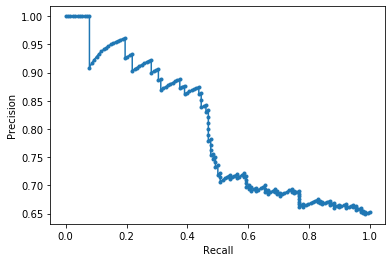

In [31]:
# plot precision recall curve
precision_recall(cosinus_results, relevant_results)

### NHTSA

In [ ]:
# drop view RELEVANT_CMPLID
sql_drop_view = 'drop view RELEVANT_CMPLID'
cursor.execute(sql_drop_view)

In [ ]:
# create view RELEVANT_CMPLID
sql = 'create view RELEVANT_CMPLID as SELECT CMPLID FROM "SYSTEM"."CMPL100K" where COMPDESC = \'AIR BAGS\' or COMPDESC = \'TIRES\' or COMPDESC = \'AIR BAGS:FRONTAL\''
cursor.execute(sql)

In [ ]:
# create tabele QUERY_NHTSA
sql = 'CREATE TABLE QUERY_NHTSA (TA_TOKEN varchar(255), count int);'
cursor.execute(sql)

In [ ]:
# delete table content
sql = 'DELETE FROM QUERY_NHTSA'
cursor.execute(sql)

In [ ]:
# insert query vector
sql = 'INSERT INTO QUERY_NHTSA (TA_TOKEN, count) VALUES (\'AIR\', 2);'
cursor.execute(sql)
sql = 'INSERT INTO QUERY_NHTSA (TA_TOKEN, count) VALUES (\'BAG\', 2);'
cursor.execute(sql)
sql = 'INSERT INTO QUERY_NHTSA (TA_TOKEN, count) VALUES (\'DEPLOYMENT\', 2);'
cursor.execute(sql)
sql = 'INSERT INTO QUERY_NHTSA (TA_TOKEN, count) VALUES (\'ACCIDENT\', 2);'
cursor.execute(sql)

In [ ]:
# drop view COS_SIM_NHTSA
sql_drop_view = 'drop view COS_SIM_NHTSA'
cursor.execute(sql_drop_view)

In [ ]:
sql = '''CREATE view COS_SIM_NHTSA as
SELECT document, sum(skalar), sum(skalar)/(sqrt(doc_count_nouns)*sqrt(search_count_nouns)) as cosinus
FROM (SELECT t1.document,
               t1.count,
               t2.count,
               t3.doc_count_nouns,
               t4.search_count_nouns,
               sum(t1.count * t2.count) as skalar
        FROM   (SELECT t1.ta_token as noun,
                       t1.cmplid as document,
                       count(*) as count
                FROM   "SYSTEM"."$TA_CDESCRIND" as t1
                WHERE  t1.ta_type = 'noun'
                GROUP  BY t1.ta_token, t1.cmplid) as t1,
               (SELECT t1.ta_token as noun, count
                FROM   QUERY_NHTSA as t1) AS t2,
               (SELECT sum(count_nouns * count_nouns) as doc_count_nouns, document
                FROM   (SELECT t1.ta_token,
                               t1.cmplid as document,
                               count(*) as count_nouns
                        FROM   "SYSTEM"."$TA_CDESCRIND" as t1
                        WHERE  t1.ta_type = 'noun'
                        GROUP  BY t1.cmplid, t1.ta_token)
                GROUP  BY document) as t3,
               (SELECT Sum(query_count_nouns * query_count_nouns) as search_count_nouns
                FROM   (SELECT t1.ta_token, 
                               sum(count) as query_count_nouns
                        FROM   QUERY_NHTSA as t1
                        GROUP  BY t1.ta_token)) as t4
        WHERE  t2.noun = t1.noun and t1.document = t3.document
        GROUP  BY t1.document,
                  t1.count,
                  t2.count,
                  t3.doc_count_nouns,
                  t4.search_count_nouns)
GROUP  BY document,
          doc_count_nouns,
          search_count_nouns
ORDER  BY cosinus desc 
'''
cursor.execute(sql)

In [22]:
# table with cosine similarity
sql = 'select top 200 document, cosinus from COS_SIM_NHTSA'
cursor.execute(sql)
cosinus_results = cursor.fetchall()

lr_probs = list(pd.DataFrame(cosinus_results).loc[:, 1].astype(float))

# relevant documents
sql = 'select cmplid from RELEVANT_CMPLID'

cursor.execute(sql)

relevant_results = cursor.fetchall()

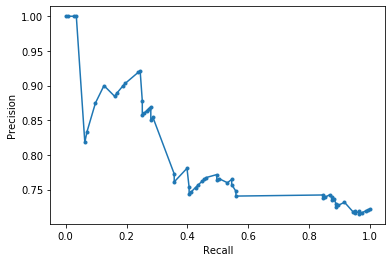

In [28]:
# plot precision recall curve
precision_recall(cosinus_results,relevant_results)